# KDP retrieval and R(KDP) vs R(Z)

Notebook on KDP Retrieval and rain rate estimation comparing R(KDP) and R(Z) for a single scan

In [1]:
%pylab inline

import pyart
import wradlib as wrl
import pandas as pd
import tempfile
import os
import datetime as dt
from dateutil import tz
import numpy as np

import netCDF4

import matplotlib.pyplot as plt
from siphon.simplewebservice.wyoming import WyomingUpperAir

import cartopy.crs as ccrs
import pytz

from skewt import SkewT

import boto3
from botocore.handlers import disable_signing

from csu_radartools import (csu_fhc, csu_liquid_ice_mass, csu_blended_rain, 
                            csu_dsd, csu_kdp, csu_misc, fundamentals) 

Populating the interactive namespace from numpy and matplotlib

## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\pyart\graph\cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\pyart\graph\cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\botocore\vendored\requests\packages\urllib3\_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, MutableMapping


### Define functions

In [2]:
def get_radar_scan(station='KLOT', date=None, key_index=-20):
    
    '''
    Function will pull the latest radar scan from any radar site using 
    Amazon S3.
    ----------
    Station = Four letter NEXRAD identifier
              Example: 'KEPZ'
    Date = default is none for current date, else enter date in format "YYYY/MM/DD"
    Ex: date ='2013/11/17
    Key_index = Number of keys you want pulled from most recent scan.
    Ex: key_index = -15 would pull ht most recent 15 scans
    '''
    
    # Creating a bucket and a client to be able to pull data from AWS and setting it as unsigned
    bucket = 'noaa-nexrad-level2'
    s3 = boto3.resource('s3')
    s3.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
    
    # Connects the bucket create above with radar data
    aws_radar = s3.Bucket(bucket)
    
    # Setting the date and time to current...
    # This will allow for allow the current date's radar scands to be pulled
    if date == None:
        target_string = datetime.datetime.utcnow().strftime('%Y/%m/%d/'+station)
    else:
        target_string = date+'/'+station
    
    for obj in aws_radar.objects.filter(Prefix= target_string):
        '{0}:{1}'.format(aws_radar.name, obj.key)
    my_list_of_keys = [this_object.key for this_object in aws_radar.objects.filter(Prefix= target_string)]
    keys = my_list_of_keys[key_index:]
    newkeys = []
    for key in keys:
        if 'MDM' in key:
            pass
        elif key.endswith('.tar'):
            pass
        else:
            newkeys.append(key)
    #print(newkeys)
    return aws_radar, newkeys

In [3]:
def radar_coords_to_cart(rng, az, ele, debug=False):
    """
    TJL - taken from old Py-ART version
    Calculate Cartesian coordinate from radar coordinates
    Parameters
    ----------
    rng : array
        Distances to the center of the radar gates (bins) in kilometers.
    az : array
        Azimuth angle of the radar in degrees.
    ele : array
        Elevation angle of the radar in degrees.
    Returns
    -------
    x, y, z : array
        Cartesian coordinates in meters from the radar.
    Notes
    -----
    The calculation for Cartesian coordinate is adapted from equations
    2.28(b) and 2.28(c) of Doviak and Zrnic [1]_ assuming a
    standard atmosphere (4/3 Earth's radius model).
    .. math::
        z = \\sqrt{r^2+R^2+r*R*sin(\\theta_e)} - R
        s = R * arcsin(\\frac{r*cos(\\theta_e)}{R+z})
        x = s * sin(\\theta_a)
        y = s * cos(\\theta_a)
    Where r is the distance from the radar to the center of the gate,
    :math:\\theta_a is the azimuth angle, :math:\\theta_e is the
    elevation angle, s is the arc length, and R is the effective radius
    of the earth, taken to be 4/3 the mean radius of earth (6371 km).
    References
    ----------
    .. [1] Doviak and Zrnic, Doppler Radar and Weather Observations, Second
        Edition, 1993, p. 21.
    """
    theta_e = ele * np.pi / 180.0  # elevation angle in radians.
    theta_a = az * np.pi / 180.0  # azimuth angle in radians.
    R = 6371.0 * 1000.0 * 4.0 / 3.0  # effective radius of earth in meters.
    r = rng * 1000.0  # distances to gates in meters.

    z = (r ** 2 + R ** 2 + 2.0 * r * R * np.sin(theta_e)) ** 0.5 - R
    s = R * np.arcsin(r * np.cos(theta_e) / (R + z))  # arc length in m.
    x = s * np.sin(theta_a)
    y = s * np.cos(theta_a)
    return x, y, z


def get_z_from_radar(radar):
    """Input radar object, return z from radar (km, 2D)"""
    azimuth_1D = radar.azimuth['data']
    elevation_1D = radar.elevation['data']
    srange_1D = radar.range['data']
    sr_2d, az_2d = np.meshgrid(srange_1D, azimuth_1D)
    el_2d = np.meshgrid(srange_1D, elevation_1D)[1]
    xx, yy, zz = radar_coords_to_cart(sr_2d/1000.0, az_2d, el_2d)
    return zz + radar.altitude['data']


def check_sounding_for_montonic(sounding):
    """
    So the sounding interpolation doesn't fail, force the sounding to behave
    monotonically so that z always increases. This eliminates data from
    descending balloons.
    """
    snd_T = sounding.soundingdata['temp']  # In old SkewT, was sounding.data
    snd_z = sounding.soundingdata['hght']  # In old SkewT, was sounding.data
    dummy_z = []
    dummy_T = []
    if not snd_T.mask[0]: #May cause issue for specific soundings
        dummy_z.append(snd_z[0])
        dummy_T.append(snd_T[0])
        for i, height in enumerate(snd_z):
            if i > 0:
                if snd_z[i] > snd_z[i-1] and not snd_T.mask[i]:
                    dummy_z.append(snd_z[i])
                    dummy_T.append(snd_T[i])
        snd_z = np.array(dummy_z)
        snd_T = np.array(dummy_T)
    return snd_T, snd_z


def interpolate_sounding_to_radar(sounding, radar):
    """Takes sounding data and interpolates it to every radar gate."""
    radar_z = get_z_from_radar(radar)
    radar_T = None
    snd_T, snd_z = check_sounding_for_montonic(sounding)
    shape = np.shape(radar_z)
    rad_z1d = radar_z.ravel()
    rad_T1d = np.interp(rad_z1d, snd_z, snd_T)
    return np.reshape(rad_T1d, shape), radar_z

In [4]:
def rounder(t):
    """
    Rounds the time to the nearest hour.
    """
    if t.minute >= 30:
        return t.replace(second=0, microsecond=0, minute=0, hour=t.hour+1)
    else:
        return t.replace(second=0, microsecond=0, minute=0)

In [5]:
def add_field_to_radar_object(field, radar, field_name='FH', units='unitless', 
                              long_name='Hydrometeor ID', standard_name='Hydrometeor ID',
                              dz_field='reflectivity'):
    
    # Add new fields to the radar object:
    # If reflectivity is a masked array, make the new field masked the same as reflectivity.
    
    fill_value = -32768
    masked_field = np.ma.asanyarray(field)
    gatefilter = pyart.filters.GateFilter(radar)
    gatefilter.exclude_below(dz_field, 20)
    masked_field.mask = masked_field == fill_value
    if hasattr(radar.fields[dz_field]['data'], 'mask'):
        setattr(masked_field, 'mask', 
                np.logical_or(masked_field.mask, radar.fields[dz_field]['data'].mask))
        fill_value = radar.fields[dz_field]['_FillValue']
    field_dict = {'data': masked_field,
                  'units': units,
                  'long_name': long_name,
                  'standard_name': standard_name,
                  '_FillValue': fill_value}
    radar.add_field(field_name, field_dict, replace_existing=True)
    return radar

In [6]:
def two_panel_plot(radar, sweep=0, var1='reflectivity', vmin1=0, vmax1=65,
                   cmap1='RdYlBu_r', units1='dBZ', var2='differential_reflectivity',
                   vmin2=-5, vmax2=5, cmap2='RdYlBu_r', units2='dB', return_flag=False,
                   xlim=[-150,150], ylim=[-150,150]):
    fig = plt.figure(figsize=[12,8])
    utc = netCDF4.num2date(radar.time['data'][0],
                       radar.time['units'])
    print(str(utc))
    z = dt.datetime.strptime(str(utc), '%Y-%m-%d %H:%M:%S.%f')

    from_zone = tz.tzutc()
    to_zone = tz.tzlocal()
    z = z.replace(tzinfo=from_zone)
    central = z.astimezone(to_zone)
    t = dt.datetime.strftime(central, '%Y/%m/%d')
    m = dt.datetime.strftime(central, ' %I:%M%p')

    
    
    display = pyart.graph.RadarDisplay(radar)
    fig = plt.figure(figsize=(13,5))
    ax1 = fig.add_subplot(121)
    
    display.plot_ppi(var1, sweep=sweep, vmin=vmin1, vmax=vmax1, cmap=cmap1, 
                     colorbar_label=units1, mask_outside=True) 
    ax1.set_title(t + m + '\n2.0 km KLOT Differential Phase Shift', fontsize=16)
    display.set_limits(xlim=xlim, ylim=ylim)
    ax2 = fig.add_subplot(122)
    display.plot_ppi(var2, sweep=sweep, vmin=vmin2, vmax=vmax2, cmap=cmap2, 
                     colorbar_label=units2, mask_outside=True) 
    ax2.set_title(t + m + '\n2.0 km KLOT Specific Differential Phase', fontsize=16)
    display.set_limits(xlim=xlim, ylim=ylim)
    if return_flag:
        return fig, ax1, ax2, display

In [7]:
def extract_unmasked_data(radar, field, bad=-32768):
    """Simplify getting unmasked radar fields from Py-ART"""
    return radar.fields[field]['data'].filled(fill_value=bad)

### Define parameters:

In [8]:
datestr = '2013-04-18 12:00:00'
radarstation = 'KLOT'

Convert date string to datettime object.

In [9]:
datestr_obj = dt.datetime.strptime(datestr,'%Y-%m-%d %H:%M:%S')

### Upper Air Sounding

Download the Upper Air Sounding data and convert it to a dictionary that can be read by the `SkewT.Sounding` function.

In [10]:
dataset = WyomingUpperAir.request_data(datestr_obj, 'ILX')

In [11]:
snddata = dict(zip(('hght','pres','temp','dwpt'),(dataset['height'],
                                                 dataset['pressure'],
                                                 dataset['temperature'],
                                                 dataset['dewpoint'])))

In [12]:
sounding = SkewT.Sounding(soundingdata=snddata)

### Download radar data

Download and read all the radar data for the specified date.

In [13]:
# Setting radar, date of radar scans needed, and key index (amount of items in list)
aws_radar, keys = get_radar_scan(station=radarstation, date=dt.datetime.strftime(datestr_obj,'%Y/%m/%d'), key_index=-400) 

Select a file from the list. Save it to a temporary file.

In [48]:
sel_key = keys[185]

In [49]:
# open a temporary local file
localfile = tempfile.NamedTemporaryFile(delete=False)
localfile_name = localfile.name
localfile.close()

In [51]:
# download to temporary file and read to radar object using pyart
aws_radar.download_file(sel_key, localfile_name)
radar = pyart.io.read(localfile_name)

# delete temporary file to save space
os.remove(localfile_name)

Preparing the data for KDP processing.

In [20]:
dzN = extract_unmasked_data(radar, 'reflectivity')
dpN = extract_unmasked_data(radar, 'differential_phase')
# Range needs to be supplied as a variable, and it needs to be the same shape as dzN, etc.
rng2d, az2d = np.meshgrid(radar.range['data'], radar.azimuth['data'])

Use CSU Radar Tools KDP calculation using the method by V. N. Bringi and Yanting Wang of CSU Electrical Engineering

In [54]:
%%time
kdN, fdN, sdN = csu_kdp.calc_kdp_bringi(
    dp=dpN, dz=dzN, rng=rng2d/1000.0, thsd=12, gs=250.0, window=5)

Wall time: 4.85 s


Add the derived variables to the radar field.

In [55]:
radar = add_field_to_radar_object(kdN, radar, field_name='KDP', units='deg/km', 
                                   long_name='Specific Differential Phase',
                                   standard_name='Specific Differential Phase', 
                                   dz_field='reflectivity')
radar = add_field_to_radar_object(fdN, radar, field_name='FDP', units='deg', 
                                   long_name='Filtered Differential Phase',
                                   standard_name='Filtered Differential Phase', 
                                   dz_field='reflectivity')
radar = add_field_to_radar_object(sdN, radar, field_name='SDP', units='deg', 
                                   long_name='Standard Deviation of Differential Phase',
                                   standard_name='Standard Deviation of Differential Phase', 
                                   dz_field='reflectivity')

Plot PhiDP and KDP

2013-04-18 13:19:12.406000


<Figure size 864x576 with 0 Axes>

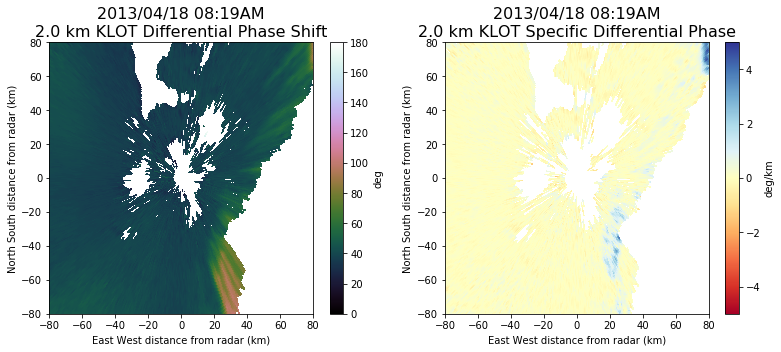

In [23]:
two_panel_plot(radar, sweep=0, var1='FDP', vmin1=0, vmax1=180, 
            cmap1='cubehelix', units1='deg',
            var2='KDP', vmin2=-5, vmax2=5, cmap2='RdYlBu', units2='deg/km', 
            xlim=[-80,80], ylim=[-80,80])


### Rainfall retrieval

Two methods of rainfall retrieval are used here: 
$R(Z)$ and $R(K_{DP})$

In [1]:
# R(Z)
rr_z = pyart.retrieve.est_rain_rate_z(radar, refl_field='reflectivity')
# R(KDP)
rr_kdp = pyart.retrieve.est_rain_rate_kdp(radar, kdp_field='KDP')

NameError: name 'pyart' is not defined

Add the rain rate fields to radar object.

In [26]:
radar = add_field_to_radar_object(rr_kdp['data'], radar, field_name='RR_from_KDP', units='mm/hr', 
                                   long_name='Rainrate from KDP',
                                   standard_name='Rainrate from KDP', 
                                   dz_field='reflectivity')

radar = add_field_to_radar_object(rr_z['data'], radar, field_name='RR_from_Z', units='mm/hr', 
                                   long_name='Rainrate from Z',
                                   standard_name='Rainrate from Z', 
                                   dz_field='reflectivity')

### Gridding the data

In [27]:
gatefilter = pyart.filters.GateFilter(radar)
# Develop your gatefilter first
# exclude masked gates from the gridding
#gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_transition()
gatefilter.exclude_masked('reflectivity')

In [28]:
grid = pyart.map.grid_from_radars(
    [radar], gatefilters=[gatefilter],
    grid_shape=(1, 300, 300),
    grid_limits=((2000, 2000), (-123000.0, 123000.0), (-123000.0, 123000.0)),
    fields=['RR_from_Z','RR_from_KDP'])

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


2013-04-18 13:19:12.406000


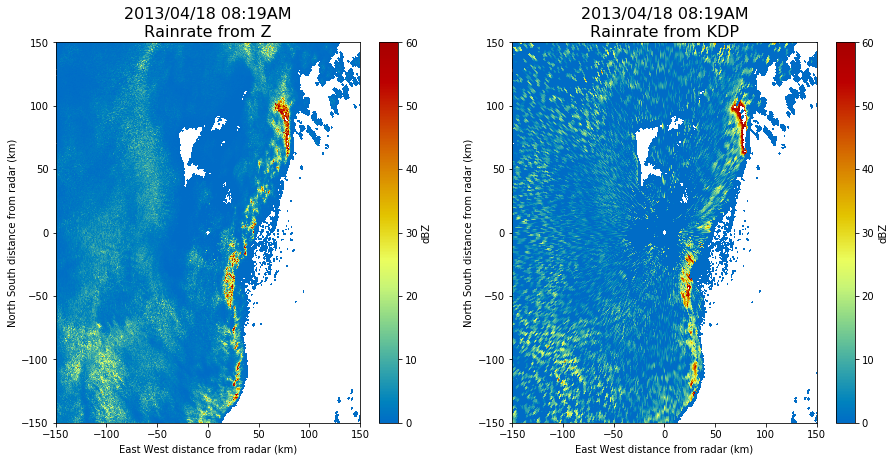

In [32]:
display = pyart.graph.RadarDisplay(radar)

utc = netCDF4.num2date(radar.time['data'][0],
                   radar.time['units'])
print(str(utc))
z = dt.datetime.strptime(str(utc), '%Y-%m-%d %H:%M:%S.%f')

from_zone = tz.tzutc()
to_zone = tz.tzlocal()
z = z.replace(tzinfo=from_zone)
central = z.astimezone(to_zone)
t = dt.datetime.strftime(central, '%Y/%m/%d')
m = dt.datetime.strftime(central, ' %I:%M%p')


fig = plt.figure(figsize=(15,7))
# RR from Z
ax1 = fig.add_subplot(121)
display.plot_ppi('RR_from_Z', vmin=0, vmax=60, cmap=pyart.graph.cm_colorblind.HomeyerRainbow, 
                 colorbar_label='dBZ', mask_outside=True)
ax1.set_title(t + m + '\nRainrate from Z', fontsize=16)
display.set_limits(xlim=[-150,150], ylim=[-150,150])

# RR from KDP
ax2 = fig.add_subplot(122)
display.plot_ppi('RR_from_KDP', vmin=0, vmax=60, cmap=pyart.graph.cm_colorblind.HomeyerRainbow, 
                 colorbar_label='dBZ', mask_outside=True) 
ax2.set_title(t + m + '\nRainrate from KDP', fontsize=16)
display.set_limits(xlim=[-150,150], ylim=[-150,150])

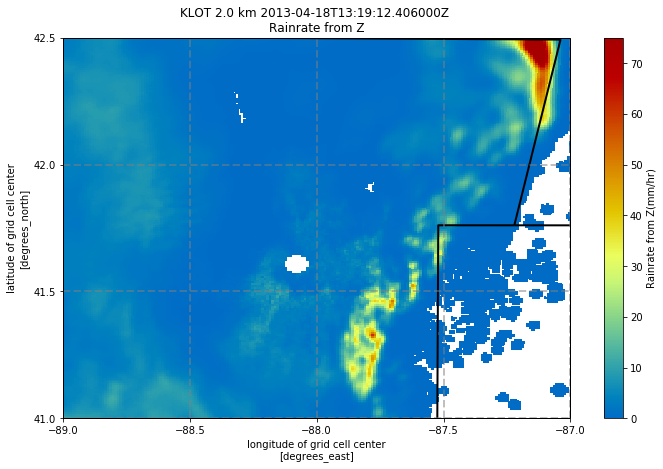

In [33]:
projection = ccrs.PlateCarree()

fig = plt.figure(figsize=[12,7])
display = pyart.graph.GridMapDisplay(grid)
display.plot_grid('RR_from_Z', cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                  vmin=0, vmax=75, lat_lines=np.arange(41, 43, .5),
                  lon_lines=np.arange(-89, -86.5, .5), projection=projection, embelish=True)

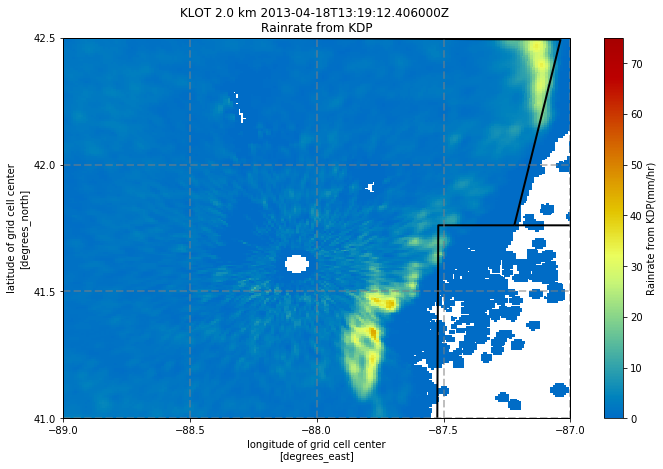

In [34]:
fig = plt.figure(figsize=[12,7])
display = pyart.graph.GridMapDisplay(grid)
display.plot_grid('RR_from_KDP', cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                  vmin=0, vmax=75, lat_lines=np.arange(41, 43, .5),
                  lon_lines=np.arange(-89, -86.5, .5), projection=projection, embelish=True)

In [35]:
# load CCN gauge locations
CCN_gauge_locations_fname = 'C:/Users/iac6311/Documents/Work/Data/Cook_County/CookCounty_gage_locations.csv'
# load CCN gauge observations
CCN_gauge_observations_fname = 'C:/Users/iac6311/Documents/Work/Data/Cook_County/WaterYear2013.csv'

In [36]:
df_gauge_loc = pd.read_csv(CCN_gauge_locations_fname,header=0)
df_gauge = pd.read_csv(CCN_gauge_observations_fname,header=0)

In [37]:
x = df_gauge_loc['Longitude - West'].values
y = df_gauge_loc['Latitude'].values

In [38]:
df_gauge['Datetime'] = pd.to_datetime(df_gauge['Date/Time'])

In [39]:
# set the timezone
timezone = pytz.timezone("America/Chicago")
df_gauge['Datetime'] = df_gauge['Datetime'].dt.tz_localize(timezone,ambiguous='NaT',nonexistent ='NaT')

In [40]:
dtime_utc = pytz.utc.localize(utc)
dtime_local = dtime_utc.astimezone(timezone)

In [41]:
dtime_local_hr = rounder(dtime_local)

In [42]:
gauge_values = df_gauge.loc[df_gauge['Datetime'] == dtime_local_hr][df_gauge.columns[1:26]].values[0]*25.4

In [43]:
radar_slice0 = radar.get_slice(0)
rr_0 = radar.fields['RR_from_KDP']['data'][radar_slice0, :]

In [44]:
sitecoords = (radar.longitude['data'][0],radar.latitude['data'][0])
az = radar.azimuth['data'][radar_slice0]
r = radar.range['data']

In [45]:
proj = wrl.georef.epsg_to_osr(4326)

In [46]:
polarneighbs = wrl.verify.PolarNeighbours(r, az, sitecoords, proj, x,y, nnear=9)
radar_at_gages = polarneighbs.extract(rr_0)

radar_at_gages_mean = np.mean(radar_at_gages,axis=1)

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\wradlib\georef\polar.py:503: UserWarning: The azimuth angles of the current dataset are not equidistant.
  "dataset are not equidistant.", UserWarning)


(0, 20)

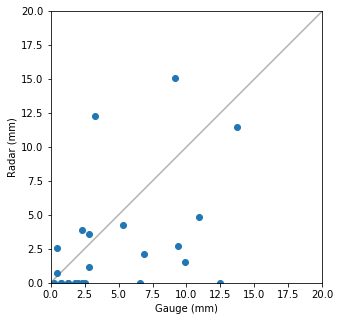

In [47]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111,aspect='equal')
plt.scatter(gauge_values,radar_at_gages_mean)
plt.plot((0,60),(0,60),color='0.7',zorder=-.5)
plt.xlabel('Gauge (mm)')
plt.ylabel('Radar (mm)')
plt.xlim(0,20)
plt.ylim(0,20)